# ResNets


*   ResNet-18
*   ResNet-w2x(wider) -128 filters
*   ResNet-0.5x(narrower) - 32 filters
*   ResNet-164 - deep
https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/





In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import timm


import os

import matplotlib.pyplot as plt


device = torch.device('cuda')

In [2]:
import torch
print(torch.cuda.is_available())

True


# Download Data


train data length: 78
test data length: 78
tensor(4)
tensor(8)
tensor(8)


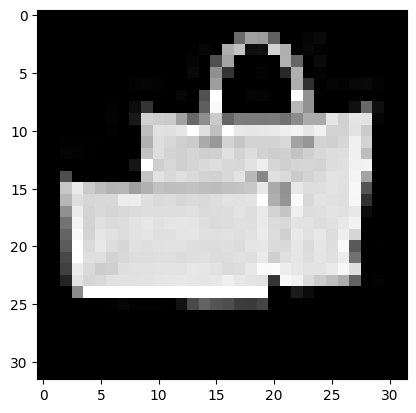

In [2]:
#config

TRAIN_SIZE  = 10000
BATCH_SIZE = 128
DATA  = "FMNIST"

##### DATA LOADER

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms


# Image preprocessing modules
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding = 4),
    transforms.ToTensor()])

if DATA == "FMNIST":
  data_set = FashionMNIST(
      # データセットのパス
      root='../../data/',
      train=True,
      # ダウンロードしている場合はdownload=False
      download=True,
      transform=transform
  )

  test_set = FashionMNIST(
      # データセットのパス
      root='../../data/',
      train=False,
      # ダウンロードしている場合はdownload=False
      download=True,
      transform=transform
  )
elif DATA == "MNIST":
  data_set = MNIST(
      # データセットのパス
      root='../../data/',
      train=True,
      # ダウンロードしている場合はdownload=False
      download=True,
      transform=transform
  )

  test_set = MNIST(
      # データセットのパス
      root='../../data/',
      train=False,
      # ダウンロードしている場合はdownload=False
      download=True,
      transform=transform
  )

data_set.data=data_set.data[:TRAIN_SIZE]
data_set.targets =data_set.targets[:TRAIN_SIZE]

data_loader = DataLoader(
    dataset=data_set, 
    batch_size=BATCH_SIZE,
    # シャッフルしない場合はshuffle=Flase
    shuffle=True,
    # batch_sizeを固定
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_set, 
    batch_size=BATCH_SIZE,
    # シャッフルしない場合はshuffle=Flase
    shuffle=True,
    # batch_sizeを固定
    drop_last=True
)

print("train data length:",len(data_loader))
print("test data length:",len(test_loader))

for idx, (inputs,label) in enumerate(test_loader):

    # move to device
    plt.imshow(inputs[0].reshape(32,32), cmap="gray")
    print(label[0])
    if idx == 2:
        break

In [3]:
#train
import torch
from torch import nn, optim
from tqdm import tqdm
def train(model, is_stitch = False,total_epoch: int=20):
   
    total_epoch = 64000//len(data_loader)+100
    # オプティマイザーの定義
    if is_stitch:
        optimizer = optim.Adam(
            params=model.parameters(),
            lr=0.001)
        # scheduler = optim.lr_scheduler.CosineAnnealingLR(
        #     optimizer=optimizer,
        # )
    else:
        optimizer = optim.SGD(
            params=model.parameters(),
            lr=0.05,
            weight_decay = 0.0001,
            momentum = 0.9
        )
        # スケジューラーの定義
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer=optimizer,
            milestones = [total_epoch//2,(total_epoch)*3//4],
            gamma = 0.2,
            last_epoch=-1, #change step to 64K 
        )

    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()

    model.train()
    i= 0
    for epoch in range(total_epoch):
        accuracy, train_loss = 0.0, 0.0

        # tqdmを用いるとプログレスバーの表示ができる
        for images, labels in tqdm(data_loader):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)

            # モデルからの出力
            out = model(images)
            # lossの算出
            loss = criterion(out, labels)

            loss.backward()
            optimizer.step()
            

            # 推測値
            preds = out.argmax(axis=1)

            train_loss += loss.item()
            # 正答率の算出
            accuracy += torch.sum(preds == labels).item() / len(labels)
            i+=1
            if i == 64000:
                return
        if not is_stitch:
            scheduler.step()

        # 値の出力
        print(f"epoch: {epoch + 1}")
        print(f"loss: {train_loss / len(data_loader)}")
        print(f"accuracy: {accuracy / len(data_loader)}")
  #  torch.save(model.state_dict(), "/content/drive/MyDrive/CompWeb/FMNISTmodel.pth")


In [4]:
def evaluate_model(model):
    correct = 0
    total = 0
    accuracy, test_loss = 0.0, 0.0
    criterion = nn.CrossEntropyLoss()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            out = model(images)
            preds = out.argmax(axis = 1)
            # calculate loss from test
            loss = criterion(out, labels)
            test_loss += loss.item()
            accuracy += torch.sum(preds == labels).item() / len(labels)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(out.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
    print(f'Loss of the network on the 10000 test images: {100 * test_loss / len(test_loader)} %')

    print(f"loss: {test_loss / len(data_loader)}")
    print(f"accuracy: {accuracy / len(data_loader)}")

# Train Model

In [ ]:
from torch.nn import Conv2d
model    = timm.create_model(model_name = 'resnet18', pretrained = True)
model.conv1 = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, 10)
model.to(device)
try:
    train(model,is_stitch=False)
except:
    torch.save(model.state_dict(), "/"+DATA+"ResNet18model"+str(TRAIN_SIZE)+".pth")
torch.save(model.state_dict(), "/"+DATA+"ResNet18model"+str(TRAIN_SIZE)+".pth")

# Reload Pretrained Model

In [5]:
#config
# MODELB->MODELA
#modelB
MODELB ="MNIST"
B_PATH = MODELB+"model/"+ MODELB +"ResNet18model10000.pth"

#modelA
MODELA ="FMNIST"
A_PATH = MODELA+"model/"+ MODELA +"ResNet18model10000.pth"

In [6]:
modelA  = timm.create_model(model_name = 'resnet18', pretrained = False)
modelA.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
modelA.fc = nn.Linear(512, 10)
modelA.to(device)

checkpoint = torch.load(A_PATH)
# load model weights state_dict
# model.load_state_dict(checkpoint['model_state_dict'])
modelA.load_state_dict(checkpoint)
modelA.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [10]:
evaluate_model(modelA)

Accuracy of the network on the 10000 test images: 11.528445512820513 %
Loss of the network on the 10000 test images: 658.3590330221714 %
loss: 6.583590330221714
accuracy: 0.11528445512820513


In [12]:
modelB  = timm.create_model(model_name = 'resnet18', pretrained = False)
modelB.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
modelB.fc = nn.Linear(512, 10)
modelB.to(device)

checkpoint = torch.load(B_PATH)
# load model weights state_dict
# model.load_state_dict(checkpoint['model_state_dict'])
modelB.load_state_dict(checkpoint)
modelB.eval()


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [13]:
evaluate_model(modelB)

Accuracy of the network on the 10000 test images: 98.68790064102564 %
Loss of the network on the 10000 test images: 5.466532010681336 %
loss: 0.05466532010681336
accuracy: 0.9868790064102564


In [29]:
from torch.nn import Conv2d

def load_model(model):

  # load the model checkpoint
  checkpoint = torch.load('/content/drive/MyDrive/CompWeb/model.pth')
  # load model weights state_dict
  model.load_state_dict(checkpoint['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')
  # load trained optimizer state_dict
  #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')
  epochs = checkpoint['epoch']
  # load the criterion
  criterion = checkpoint['loss']
  print('Trained model loss function loaded...')
  print(f"Previously trained for {epochs} number of epochs...")
  # train for more epochs
  # epochs = new_epochs
  # print(f"Train for {epochs} more epochs...")


# Stitch Model class

In [14]:
class StitchedModel(nn.Module):
  def __init__(self, modelB, modelA):
    super(StitchedModel,self).__init__()
    #stitch layer 1 to  layer 2
    self.c1 = 64
    self.c2 = 64
    
    #buttom model
    self.modelBconv1 = modelB.conv1
    self.modelBbn1 = modelB.bn1
    self.modelBact1 = modelB.act1
    self.modelBmaxpool = modelB.maxpool
    self.modelBlayer1 = modelB.layer1
    self.modelBlayer2 = modelB.layer2
    self.modelBlayer3 = modelB.layer3
    self.modelBlayer4 = modelB.layer4
    self.modelBglobal_pool = modelB.global_pool
    self.modelBfc = modelB.fc
    
    #top model
    self.modelAconv1 = modelA.conv1
    self.modelAbn1 = modelA.bn1
    self.modelAact1 = modelA.act1
    self.modelAmaxpool = modelA.maxpool
    self.modelAlayer1 = modelA.layer1
    self.modelAlayer2 = modelA.layer2
    self.modelAlayer3 = modelA.layer3
    self.modelAlayer4 = modelA.layer4
    self.modelAglobal_pool = modelA.global_pool
    self.modelAfc = modelA.fc

    #stitching layer
    self.bn1 = nn.BatchNorm2d(self.c1)
    self.conv = nn.Conv2d(in_channels = self.c1, out_channels = self.c2,kernel_size=1)
    self.bn2 = nn.BatchNorm2d(self.c2)

  def forward(self,x):
    x=self.modelBconv1(x)   
    x=self.modelBbn1(x)   
    x=self.modelBact1(x)
    x=self.modelBmaxpool(x)   
    x=self.modelBlayer1(x)
    # x=self.modelBlayer2(x)
    # x=self.modelBlayer3(x)
    # x=self.modelBlayer4(x)
    # x=self.modelBglobal_pool(x)
    # x=self.modelBfc(x)
    
    x=self.bn1(x)
    x=self.conv(x)
    x=self.bn2(x)
    
    # x=self.modelAconv1(x)   
    # x=self.modelAbn1(x)   
    # x=self.modelAact1(x)
    # x=self.modelAmaxpool(x)   
    # x=self.modelAlayer1(x)
    x=self.modelAlayer2(x)
    x=self.modelAlayer3(x)
    x=self.modelAlayer4(x)
    x=self.modelAglobal_pool(x)
    x=self.modelAfc(x)

    return x



# Train Stitch Model

In [15]:
stitchmodel =StitchedModel(modelB, modelA).to(device)
#freeze layer
for param in stitchmodel.parameters():
    param.requires_grad = False

#unfreeze stitching layers
for param in stitchmodel.bn1.parameters():
    param.requires_grad = True

for param in stitchmodel.conv.parameters():
    param.requires_grad = True

for param in stitchmodel.bn2.parameters():
    param.requires_grad = True


In [16]:
evaluate_model(stitchmodel)

Accuracy of the network on the 10000 test images: 7.602163461538462 %
Loss of the network on the 10000 test images: 602.0898867876102 %
loss: 6.0208988678761015
accuracy: 0.07602163461538461


In [ ]:
try:
    print("training"+MODELB+"to"+MODELA+"trainedon"+DATA+".......")
    train(stitchmodel,is_stitch=True)
except KeyboardInterrupt:
    pass
#torch.save(stitchmodel.state_dict(), "StitchedModel/"+MODELB+"to"+MODELA+"trainedon"+DATA+"2.pth")

model_scripted = torch.jit.script(stitchmodel) # Export to TorchScript
model_scripted.save("StitchedModel(layer2)/"+MODELB+"to"+MODELA+"trainedon"+DATA+".pth") # Save

In [15]:
evaluate_model(stitchmodel)

NameError: name 'stitchmodel' is not defined

In [18]:
stitchmodel =StitchedModel(modelB=modelA,modelA= modelB).to(device)
#freeze layer
for param in stitchmodel.parameters():
    param.requires_grad = False

#unfreeze stitching layers
for param in stitchmodel.bn1.parameters():
    param.requires_grad = True

for param in stitchmodel.conv.parameters():
    param.requires_grad = True

for param in stitchmodel.bn2.parameters():
    param.requires_grad = True

try:
    print("training"+MODELA+"to"+MODELB+"trainedon"+DATA+".......")
    train(stitchmodel,is_stitch=True)
except KeyboardInterrupt:
    pass
#torch.save(stitchmodel.state_dict(), "StitchedModel/"+MODELB+"to"+MODELA+"trainedon"+DATA+"2.pth")

model_scripted = torch.jit.script(stitchmodel) # Export to TorchScript
model_scripted.save("StitchedModel(layer2)/"+MODELA+"to"+MODELB+"trainedon"+DATA+".pth") # Save

trainingFMNISTtoMNISTtrainedonMNIST.......


100%|██████████| 78/78 [00:04<00:00, 18.95it/s]


epoch: 1
loss: 1.0454222067044332
accuracy: 0.8053886217948718


100%|██████████| 78/78 [00:03<00:00, 21.51it/s]


epoch: 2
loss: 0.18195431751127428
accuracy: 0.9532251602564102


100%|██████████| 78/78 [00:03<00:00, 21.66it/s]


epoch: 3
loss: 0.13590435546416885
accuracy: 0.9651442307692307


100%|██████████| 78/78 [00:03<00:00, 22.33it/s]


epoch: 4
loss: 0.09999916930563557
accuracy: 0.9716546474358975


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 5
loss: 0.08825665431765792
accuracy: 0.9755608974358975


100%|██████████| 78/78 [00:03<00:00, 22.34it/s]


epoch: 6
loss: 0.0704210314911623
accuracy: 0.9792668269230769


100%|██████████| 78/78 [00:03<00:00, 22.00it/s]


epoch: 7
loss: 0.061492700893909506
accuracy: 0.9821714743589743


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 8
loss: 0.059763132727358684
accuracy: 0.9824719551282052


100%|██████████| 78/78 [00:03<00:00, 22.58it/s]


epoch: 9
loss: 0.049299751387503095
accuracy: 0.9862780448717948


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 10
loss: 0.05115792227055257
accuracy: 0.9840745192307693


100%|██████████| 78/78 [00:03<00:00, 22.34it/s]


epoch: 11
loss: 0.04926113438201495
accuracy: 0.9853766025641025


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 12
loss: 0.038813405320979655
accuracy: 0.9876802884615384


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 13
loss: 0.04204236839909871
accuracy: 0.9864783653846154


100%|██████████| 78/78 [00:03<00:00, 22.44it/s]


epoch: 14
loss: 0.035641547585001744
accuracy: 0.9886818910256411


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 15
loss: 0.040407741851268865
accuracy: 0.987479967948718


100%|██████████| 78/78 [00:03<00:00, 22.40it/s]


epoch: 16
loss: 0.03001642386497667
accuracy: 0.9900841346153846


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 17
loss: 0.03590923878185164
accuracy: 0.9888822115384616


100%|██████████| 78/78 [00:03<00:00, 21.77it/s]


epoch: 18
loss: 0.03551833706501967
accuracy: 0.9889823717948718


100%|██████████| 78/78 [00:03<00:00, 21.96it/s]


epoch: 19
loss: 0.036430449438436575
accuracy: 0.9892828525641025


100%|██████████| 78/78 [00:03<00:00, 22.07it/s]


epoch: 20
loss: 0.02920791031479334
accuracy: 0.9912860576923077


100%|██████████| 78/78 [00:03<00:00, 22.53it/s]


epoch: 21
loss: 0.02995116343551602
accuracy: 0.9903846153846154


100%|██████████| 78/78 [00:03<00:00, 22.43it/s]


epoch: 22
loss: 0.0313428355648051
accuracy: 0.9905849358974359


100%|██████████| 78/78 [00:03<00:00, 22.31it/s]


epoch: 23
loss: 0.031707201729146525
accuracy: 0.9892828525641025


100%|██████████| 78/78 [00:03<00:00, 22.00it/s]


epoch: 24
loss: 0.028172734084551055
accuracy: 0.9910857371794872


100%|██████████| 78/78 [00:03<00:00, 22.31it/s]


epoch: 25
loss: 0.026863154834688593
accuracy: 0.9920873397435898


100%|██████████| 78/78 [00:03<00:00, 22.49it/s]


epoch: 26
loss: 0.02249783585937574
accuracy: 0.992988782051282


100%|██████████| 78/78 [00:03<00:00, 21.33it/s]


epoch: 27
loss: 0.023723904218059033
accuracy: 0.9919871794871795


100%|██████████| 78/78 [00:03<00:00, 21.77it/s]


epoch: 28
loss: 0.023438501451612234
accuracy: 0.9924879807692307


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 29
loss: 0.024164476956521425
accuracy: 0.9925881410256411


100%|██████████| 78/78 [00:03<00:00, 21.16it/s]


epoch: 30
loss: 0.02449057286587329
accuracy: 0.9920873397435898


100%|██████████| 78/78 [00:03<00:00, 19.87it/s]


epoch: 31
loss: 0.024069945061525617
accuracy: 0.9925881410256411


100%|██████████| 78/78 [00:03<00:00, 21.01it/s]


epoch: 32
loss: 0.02308225270229368
accuracy: 0.9921875


100%|██████████| 78/78 [00:03<00:00, 21.86it/s]


epoch: 33
loss: 0.024217395552207168
accuracy: 0.9919871794871795


100%|██████████| 78/78 [00:03<00:00, 21.17it/s]


epoch: 34
loss: 0.024852014842998378
accuracy: 0.9921875


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 35
loss: 0.02490250745792694
accuracy: 0.9921875


100%|██████████| 78/78 [00:03<00:00, 21.79it/s]


epoch: 36
loss: 0.019120805055792563
accuracy: 0.9938902243589743


100%|██████████| 78/78 [00:03<00:00, 20.74it/s]


epoch: 37
loss: 0.017630278324642673
accuracy: 0.9941907051282052


100%|██████████| 78/78 [00:03<00:00, 21.14it/s]


epoch: 38
loss: 0.01883591274963692
accuracy: 0.9936899038461539


100%|██████████| 78/78 [00:04<00:00, 19.25it/s]


epoch: 39
loss: 0.019818293862791065
accuracy: 0.9930889423076923


100%|██████████| 78/78 [00:03<00:00, 20.42it/s]


epoch: 40
loss: 0.021558227522734504
accuracy: 0.992988782051282


100%|██████████| 78/78 [00:03<00:00, 21.49it/s]


epoch: 41
loss: 0.020003110009173933
accuracy: 0.9930889423076923


100%|██████████| 78/78 [00:03<00:00, 21.70it/s]


epoch: 42
loss: 0.020392851661502693
accuracy: 0.992988782051282


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 43
loss: 0.015355710450631496
accuracy: 0.9948918269230769


100%|██████████| 78/78 [00:03<00:00, 21.83it/s]


epoch: 44
loss: 0.01736692838051404
accuracy: 0.9938902243589743


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 45
loss: 0.016926061460533395
accuracy: 0.9946915064102564


100%|██████████| 78/78 [00:03<00:00, 22.07it/s]


epoch: 46
loss: 0.020716891360606473
accuracy: 0.9936899038461539


100%|██████████| 78/78 [00:03<00:00, 22.08it/s]


epoch: 47
loss: 0.016024495099629395
accuracy: 0.9946915064102564


100%|██████████| 78/78 [00:03<00:00, 21.93it/s]


epoch: 48
loss: 0.014422898353913274
accuracy: 0.9947916666666666


100%|██████████| 78/78 [00:03<00:00, 21.53it/s]


epoch: 49
loss: 0.013911282079509245
accuracy: 0.9951923076923077


100%|██████████| 78/78 [00:03<00:00, 21.96it/s]


epoch: 50
loss: 0.020189304954002205
accuracy: 0.9939903846153846


100%|██████████| 78/78 [00:03<00:00, 20.62it/s]


epoch: 51
loss: 0.018544885367214776
accuracy: 0.9932892628205128


100%|██████████| 78/78 [00:03<00:00, 21.71it/s]


epoch: 52
loss: 0.01704645833785598
accuracy: 0.9940905448717948


100%|██████████| 78/78 [00:04<00:00, 19.08it/s]


epoch: 53
loss: 0.018841070382339425
accuracy: 0.9938902243589743


100%|██████████| 78/78 [00:03<00:00, 19.91it/s]


epoch: 54
loss: 0.018072324771007214
accuracy: 0.9936899038461539


100%|██████████| 78/78 [00:04<00:00, 18.81it/s]


epoch: 55
loss: 0.01623958074271333
accuracy: 0.9946915064102564


100%|██████████| 78/78 [00:03<00:00, 20.73it/s]


epoch: 56
loss: 0.014783348705700168
accuracy: 0.9949919871794872


100%|██████████| 78/78 [00:03<00:00, 21.71it/s]


epoch: 57
loss: 0.01707034475970058
accuracy: 0.9941907051282052


100%|██████████| 78/78 [00:03<00:00, 20.97it/s]


epoch: 58
loss: 0.017212123900744468
accuracy: 0.9942908653846154


100%|██████████| 78/78 [00:03<00:00, 20.90it/s]


epoch: 59
loss: 0.01734955118221338
accuracy: 0.9949919871794872


100%|██████████| 78/78 [00:03<00:00, 21.98it/s]


epoch: 60
loss: 0.014634301989691524
accuracy: 0.9956931089743589


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 61
loss: 0.016493070671388593
accuracy: 0.9947916666666666


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 62
loss: 0.01910291247156401
accuracy: 0.9928886217948718


100%|██████████| 78/78 [00:03<00:00, 21.90it/s]


epoch: 63
loss: 0.01699796441169336
accuracy: 0.9946915064102564


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 64
loss: 0.017316756826356795
accuracy: 0.9948918269230769


100%|██████████| 78/78 [00:03<00:00, 22.00it/s]


epoch: 65
loss: 0.014888004120364666
accuracy: 0.9958934294871795


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 66
loss: 0.013297128208647244
accuracy: 0.9954927884615384


100%|██████████| 78/78 [00:03<00:00, 22.40it/s]


epoch: 67
loss: 0.01602559185546572
accuracy: 0.995292467948718


100%|██████████| 78/78 [00:03<00:00, 22.06it/s]


epoch: 68
loss: 0.015406935891429057
accuracy: 0.9948918269230769


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 69
loss: 0.012994273975401973
accuracy: 0.9959935897435898


100%|██████████| 78/78 [00:03<00:00, 21.65it/s]


epoch: 70
loss: 0.01618624799616205
accuracy: 0.9940905448717948


100%|██████████| 78/78 [00:03<00:00, 21.19it/s]


epoch: 71
loss: 0.013965417969768915
accuracy: 0.995292467948718


100%|██████████| 78/78 [00:03<00:00, 21.17it/s]


epoch: 72
loss: 0.013744997118826574
accuracy: 0.9958934294871795


100%|██████████| 78/78 [00:03<00:00, 21.88it/s]


epoch: 73
loss: 0.014293746145155568
accuracy: 0.995292467948718


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 74
loss: 0.01525868279620623
accuracy: 0.9955929487179487


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 75
loss: 0.013156551643101594
accuracy: 0.99609375


100%|██████████| 78/78 [00:03<00:00, 21.91it/s]


epoch: 76
loss: 0.011440749099934831
accuracy: 0.9958934294871795


100%|██████████| 78/78 [00:03<00:00, 21.58it/s]


epoch: 77
loss: 0.013925775393428735
accuracy: 0.9950921474358975


100%|██████████| 78/78 [00:03<00:00, 21.97it/s]


epoch: 78
loss: 0.014144739480495142
accuracy: 0.9953926282051282


100%|██████████| 78/78 [00:03<00:00, 22.52it/s]


epoch: 79
loss: 0.01317545696749734
accuracy: 0.9959935897435898


100%|██████████| 78/78 [00:03<00:00, 20.87it/s]


epoch: 80
loss: 0.013760402662461648
accuracy: 0.9951923076923077


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 81
loss: 0.015538750177186627
accuracy: 0.9948918269230769


100%|██████████| 78/78 [00:03<00:00, 20.59it/s]


epoch: 82
loss: 0.012810796468655985
accuracy: 0.9954927884615384


100%|██████████| 78/78 [00:03<00:00, 20.40it/s]


epoch: 83
loss: 0.015039295136095742
accuracy: 0.9949919871794872


100%|██████████| 78/78 [00:03<00:00, 20.94it/s]


epoch: 84
loss: 0.014521485972904768
accuracy: 0.9951923076923077


100%|██████████| 78/78 [00:03<00:00, 20.62it/s]


epoch: 85
loss: 0.014432235859343424
accuracy: 0.9949919871794872


100%|██████████| 78/78 [00:03<00:00, 21.05it/s]


epoch: 86
loss: 0.011977781230831543
accuracy: 0.9962940705128205


100%|██████████| 78/78 [00:03<00:00, 21.50it/s]


epoch: 87
loss: 0.012163688506310185
accuracy: 0.9958934294871795


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 88
loss: 0.013918559665818555
accuracy: 0.9943910256410257


100%|██████████| 78/78 [00:03<00:00, 21.83it/s]


epoch: 89
loss: 0.012890181375461487
accuracy: 0.9957932692307693


100%|██████████| 78/78 [00:03<00:00, 21.64it/s]


epoch: 90
loss: 0.01191027474273235
accuracy: 0.9961939102564102


100%|██████████| 78/78 [00:03<00:00, 21.66it/s]


epoch: 91
loss: 0.016064248567160506
accuracy: 0.9943910256410257


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 92
loss: 0.011082371693844788
accuracy: 0.9957932692307693


100%|██████████| 78/78 [00:03<00:00, 22.11it/s]


epoch: 93
loss: 0.016320588666414365
accuracy: 0.9938902243589743


100%|██████████| 78/78 [00:03<00:00, 21.84it/s]


epoch: 94
loss: 0.012589886163298685
accuracy: 0.99609375


100%|██████████| 78/78 [00:03<00:00, 21.72it/s]


epoch: 95
loss: 0.013887270225379139
accuracy: 0.9953926282051282


100%|██████████| 78/78 [00:03<00:00, 21.96it/s]


epoch: 96
loss: 0.011068139665533239
accuracy: 0.9961939102564102


100%|██████████| 78/78 [00:03<00:00, 19.96it/s]


epoch: 97
loss: 0.00931984646908509
accuracy: 0.996895032051282


100%|██████████| 78/78 [00:03<00:00, 21.37it/s]


epoch: 98
loss: 0.008710709852517212
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 20.59it/s]


epoch: 99
loss: 0.01327503883788804
accuracy: 0.9954927884615384


100%|██████████| 78/78 [00:03<00:00, 21.32it/s]


epoch: 100
loss: 0.010372171211295212
accuracy: 0.9965945512820513


100%|██████████| 78/78 [00:03<00:00, 21.64it/s]


epoch: 101
loss: 0.010957525171435032
accuracy: 0.9958934294871795


100%|██████████| 78/78 [00:03<00:00, 21.00it/s]


epoch: 102
loss: 0.012627813762474734
accuracy: 0.9958934294871795


100%|██████████| 78/78 [00:03<00:00, 21.92it/s]


epoch: 103
loss: 0.011787117946928797
accuracy: 0.9967948717948718


100%|██████████| 78/78 [00:03<00:00, 21.20it/s]


epoch: 104
loss: 0.011692727666321354
accuracy: 0.9958934294871795


100%|██████████| 78/78 [00:03<00:00, 21.84it/s]


epoch: 105
loss: 0.011139895438995713
accuracy: 0.9963942307692307


100%|██████████| 78/78 [00:03<00:00, 21.98it/s]


epoch: 106
loss: 0.012459707237445774
accuracy: 0.9951923076923077


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 107
loss: 0.013461531558930755
accuracy: 0.9959935897435898


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 108
loss: 0.011688574220244892
accuracy: 0.9957932692307693


100%|██████████| 78/78 [00:03<00:00, 21.97it/s]


epoch: 109
loss: 0.01076720586048069
accuracy: 0.9963942307692307


100%|██████████| 78/78 [00:04<00:00, 18.50it/s]


epoch: 110
loss: 0.010796517883322965
accuracy: 0.9963942307692307


100%|██████████| 78/78 [00:03<00:00, 20.54it/s]


epoch: 111
loss: 0.01286650015875542
accuracy: 0.9955929487179487


100%|██████████| 78/78 [00:03<00:00, 20.93it/s]


epoch: 112
loss: 0.014898798088184916
accuracy: 0.9948918269230769


100%|██████████| 78/78 [00:03<00:00, 21.53it/s]


epoch: 113
loss: 0.009269910038804086
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 21.16it/s]


epoch: 114
loss: 0.012621124434726646
accuracy: 0.99609375


100%|██████████| 78/78 [00:03<00:00, 21.88it/s]


epoch: 115
loss: 0.010766222812563706
accuracy: 0.9961939102564102


100%|██████████| 78/78 [00:03<00:00, 21.74it/s]


epoch: 116
loss: 0.009584154582952555
accuracy: 0.9961939102564102


100%|██████████| 78/78 [00:03<00:00, 21.93it/s]


epoch: 117
loss: 0.012622500790689046
accuracy: 0.9954927884615384


100%|██████████| 78/78 [00:03<00:00, 21.97it/s]


epoch: 118
loss: 0.013034352450258432
accuracy: 0.9957932692307693


100%|██████████| 78/78 [00:03<00:00, 20.72it/s]


epoch: 119
loss: 0.012241459572881771
accuracy: 0.995292467948718


100%|██████████| 78/78 [00:03<00:00, 21.18it/s]


epoch: 120
loss: 0.010430740443646358
accuracy: 0.9967948717948718


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 121
loss: 0.009375661832820743
accuracy: 0.9962940705128205


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 122
loss: 0.010735657948549861
accuracy: 0.9963942307692307


100%|██████████| 78/78 [00:03<00:00, 20.27it/s]


epoch: 123
loss: 0.011159916657235067
accuracy: 0.99609375


100%|██████████| 78/78 [00:03<00:00, 20.60it/s]


epoch: 124
loss: 0.009623536734486548
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:03<00:00, 21.51it/s]


epoch: 125
loss: 0.014848713798132032
accuracy: 0.9954927884615384


100%|██████████| 78/78 [00:03<00:00, 21.65it/s]


epoch: 126
loss: 0.013308644015640497
accuracy: 0.9957932692307693


100%|██████████| 78/78 [00:03<00:00, 20.79it/s]


epoch: 127
loss: 0.01302189783130486
accuracy: 0.99609375


100%|██████████| 78/78 [00:03<00:00, 21.93it/s]


epoch: 128
loss: 0.009927839259408081
accuracy: 0.9961939102564102


100%|██████████| 78/78 [00:03<00:00, 22.37it/s]


epoch: 129
loss: 0.010598272421376374
accuracy: 0.9959935897435898


100%|██████████| 78/78 [00:03<00:00, 21.78it/s]


epoch: 130
loss: 0.011839894148765896
accuracy: 0.9955929487179487


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 131
loss: 0.009585343151672695
accuracy: 0.9961939102564102


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 132
loss: 0.012679786060732275
accuracy: 0.9956931089743589


100%|██████████| 78/78 [00:03<00:00, 21.97it/s]


epoch: 133
loss: 0.009146513621463107
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 134
loss: 0.01000480754905416
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 22.36it/s]


epoch: 135
loss: 0.01100668455220353
accuracy: 0.9963942307692307


100%|██████████| 78/78 [00:03<00:00, 21.49it/s]


epoch: 136
loss: 0.010750106019445527
accuracy: 0.9962940705128205


100%|██████████| 78/78 [00:03<00:00, 21.70it/s]


epoch: 137
loss: 0.007692625707325836
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 138
loss: 0.01028739981530891
accuracy: 0.9967948717948718


100%|██████████| 78/78 [00:03<00:00, 21.05it/s]


epoch: 139
loss: 0.010165943915639311
accuracy: 0.9961939102564102


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 140
loss: 0.009751913460487954
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 21.89it/s]


epoch: 141
loss: 0.00785483020874194
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 21.43it/s]


epoch: 142
loss: 0.010979871623418055
accuracy: 0.9961939102564102


100%|██████████| 78/78 [00:04<00:00, 16.28it/s]


epoch: 143
loss: 0.010497166284506258
accuracy: 0.9961939102564102


100%|██████████| 78/78 [00:03<00:00, 20.44it/s]


epoch: 144
loss: 0.008710007229521394
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 145
loss: 0.009701537638111638
accuracy: 0.9959935897435898


100%|██████████| 78/78 [00:03<00:00, 21.24it/s]


epoch: 146
loss: 0.01151710818185865
accuracy: 0.9964943910256411


100%|██████████| 78/78 [00:03<00:00, 21.80it/s]


epoch: 147
loss: 0.009471235865464386
accuracy: 0.9967948717948718


100%|██████████| 78/78 [00:03<00:00, 21.65it/s]


epoch: 148
loss: 0.00882882882694666
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 21.91it/s]


epoch: 149
loss: 0.011797318936889777
accuracy: 0.9959935897435898


100%|██████████| 78/78 [00:03<00:00, 21.93it/s]


epoch: 150
loss: 0.010629171617881347
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 21.66it/s]


epoch: 151
loss: 0.01040579490094947
accuracy: 0.99609375


100%|██████████| 78/78 [00:04<00:00, 18.77it/s]


epoch: 152
loss: 0.008481996381679216
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 20.63it/s]


epoch: 153
loss: 0.01020463549670799
accuracy: 0.9967948717948718


100%|██████████| 78/78 [00:03<00:00, 21.46it/s]


epoch: 154
loss: 0.007683187011235322
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.18it/s]


epoch: 155
loss: 0.008377177464307094
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 20.63it/s]


epoch: 156
loss: 0.008085920155094638
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 21.74it/s]


epoch: 157
loss: 0.01092560273798135
accuracy: 0.99609375


100%|██████████| 78/78 [00:03<00:00, 21.55it/s]


epoch: 158
loss: 0.009716626683560511
accuracy: 0.9967948717948718


100%|██████████| 78/78 [00:03<00:00, 21.34it/s]


epoch: 159
loss: 0.008823034062142817
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:03<00:00, 21.55it/s]


epoch: 160
loss: 0.00975878666772937
accuracy: 0.9966947115384616


100%|██████████| 78/78 [00:03<00:00, 21.22it/s]


epoch: 161
loss: 0.011375096069875723
accuracy: 0.9956931089743589


100%|██████████| 78/78 [00:03<00:00, 21.93it/s]


epoch: 162
loss: 0.008428910710044408
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:03<00:00, 21.61it/s]


epoch: 163
loss: 0.009718813814031772
accuracy: 0.9967948717948718


100%|██████████| 78/78 [00:03<00:00, 21.08it/s]


epoch: 164
loss: 0.007577405603324923
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 21.40it/s]


epoch: 165
loss: 0.01282207306604295
accuracy: 0.9962940705128205


100%|██████████| 78/78 [00:03<00:00, 21.31it/s]


epoch: 166
loss: 0.00806432389221393
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 167
loss: 0.00963304886551132
accuracy: 0.9961939102564102


100%|██████████| 78/78 [00:03<00:00, 20.94it/s]


epoch: 168
loss: 0.01032689174369294
accuracy: 0.996895032051282


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 169
loss: 0.008870215917480752
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 22.08it/s]


epoch: 170
loss: 0.00933038219376706
accuracy: 0.996895032051282


100%|██████████| 78/78 [00:03<00:00, 21.63it/s]


epoch: 171
loss: 0.009428221513353026
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 21.30it/s]


epoch: 172
loss: 0.008913191420455964
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 21.30it/s]


epoch: 173
loss: 0.010810569529451478
accuracy: 0.9958934294871795


100%|██████████| 78/78 [00:03<00:00, 20.40it/s]


epoch: 174
loss: 0.006713269094082837
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 175
loss: 0.010330284716940533
accuracy: 0.9961939102564102


100%|██████████| 78/78 [00:03<00:00, 21.27it/s]


epoch: 176
loss: 0.008918479280859733
accuracy: 0.9967948717948718


100%|██████████| 78/78 [00:03<00:00, 21.02it/s]


epoch: 177
loss: 0.010594860380455757
accuracy: 0.9966947115384616


100%|██████████| 78/78 [00:03<00:00, 21.06it/s]


epoch: 178
loss: 0.00809346046336055
accuracy: 0.996895032051282


100%|██████████| 78/78 [00:03<00:00, 21.57it/s]


epoch: 179
loss: 0.008197935500692647
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:03<00:00, 21.86it/s]


epoch: 180
loss: 0.0108672135661786
accuracy: 0.99609375


100%|██████████| 78/78 [00:03<00:00, 19.80it/s]


epoch: 181
loss: 0.00894109421940998
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:06<00:00, 11.58it/s]


epoch: 182
loss: 0.0074282821181278005
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:05<00:00, 14.56it/s]


epoch: 183
loss: 0.007053620548387512
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:08<00:00,  9.68it/s]


epoch: 184
loss: 0.007473336949120634
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 20.71it/s]


epoch: 185
loss: 0.008386627808272934
accuracy: 0.9967948717948718


100%|██████████| 78/78 [00:03<00:00, 21.27it/s]


epoch: 186
loss: 0.008706257824833767
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:04<00:00, 15.99it/s]


epoch: 187
loss: 0.009441878411915893
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 21.33it/s]


epoch: 188
loss: 0.009619694765812406
accuracy: 0.9962940705128205


100%|██████████| 78/78 [00:03<00:00, 21.77it/s]


epoch: 189
loss: 0.010697457059555186
accuracy: 0.9964943910256411


100%|██████████| 78/78 [00:03<00:00, 21.24it/s]


epoch: 190
loss: 0.009250357956401646
accuracy: 0.9965945512820513


100%|██████████| 78/78 [00:03<00:00, 21.60it/s]


epoch: 191
loss: 0.006800330327211832
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.27it/s]


epoch: 192
loss: 0.008161910992408266
accuracy: 0.996895032051282


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 193
loss: 0.009255710478427295
accuracy: 0.9965945512820513


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 194
loss: 0.012832647520833863
accuracy: 0.9949919871794872


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 195
loss: 0.008143537671481354
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 21.18it/s]


epoch: 196
loss: 0.00921191379818946
accuracy: 0.9965945512820513


100%|██████████| 78/78 [00:03<00:00, 20.77it/s]


epoch: 197
loss: 0.008735657847211815
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 21.93it/s]


epoch: 198
loss: 0.008640102794370016
accuracy: 0.996895032051282


100%|██████████| 78/78 [00:03<00:00, 21.32it/s]


epoch: 199
loss: 0.009399229953534162
accuracy: 0.9963942307692307


100%|██████████| 78/78 [00:03<00:00, 21.39it/s]


epoch: 200
loss: 0.009037951977053383
accuracy: 0.9967948717948718


100%|██████████| 78/78 [00:03<00:00, 21.72it/s]


epoch: 201
loss: 0.009192421054766059
accuracy: 0.9966947115384616


100%|██████████| 78/78 [00:03<00:00, 20.00it/s]


epoch: 202
loss: 0.008036674470088493
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 20.85it/s]


epoch: 203
loss: 0.010377165989036886
accuracy: 0.9967948717948718


100%|██████████| 78/78 [00:03<00:00, 20.39it/s]


epoch: 204
loss: 0.005549444317950521
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.50it/s]


epoch: 205
loss: 0.01114136596077468
accuracy: 0.9963942307692307


100%|██████████| 78/78 [00:03<00:00, 21.92it/s]


epoch: 206
loss: 0.007027618505302458
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.41it/s]


epoch: 207
loss: 0.008108728547365619
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:03<00:00, 22.43it/s]


epoch: 208
loss: 0.008543435306189796
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 209
loss: 0.008853109881434089
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 210
loss: 0.0075058631784766195
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 22.26it/s]


epoch: 211
loss: 0.007770120845704626
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 21.99it/s]


epoch: 212
loss: 0.006567776951646336
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.95it/s]


epoch: 213
loss: 0.00788959784907862
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 21.94it/s]


epoch: 214
loss: 0.010009261172784206
accuracy: 0.9967948717948718


100%|██████████| 78/78 [00:03<00:00, 22.31it/s]


epoch: 215
loss: 0.007181530889610235
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 216
loss: 0.008461314654246403
accuracy: 0.9966947115384616


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 217
loss: 0.008951669229225865
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 21.81it/s]


epoch: 218
loss: 0.008305493058660665
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 219
loss: 0.006987595326977615
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 22.16it/s]


epoch: 220
loss: 0.00825384629290336
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 221
loss: 0.006694559188849197
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 222
loss: 0.00802328532266144
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 22.47it/s]


epoch: 223
loss: 0.007436172083917205
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 224
loss: 0.00841782377746989
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 22.08it/s]


epoch: 225
loss: 0.008391197696955014
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 22.59it/s]


epoch: 226
loss: 0.00867353464426019
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 22.39it/s]


epoch: 227
loss: 0.00736137134849858
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 228
loss: 0.008957232396381024
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:03<00:00, 22.07it/s]


epoch: 229
loss: 0.008554932792321779
accuracy: 0.9966947115384616


100%|██████████| 78/78 [00:03<00:00, 21.97it/s]


epoch: 230
loss: 0.01044518353853327
accuracy: 0.9964943910256411


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 231
loss: 0.010576817936499795
accuracy: 0.9965945512820513


100%|██████████| 78/78 [00:03<00:00, 22.11it/s]


epoch: 232
loss: 0.00854884133001085
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 22.44it/s]


epoch: 233
loss: 0.008643963442479547
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 21.92it/s]


epoch: 234
loss: 0.00781052840876584
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 20.83it/s]


epoch: 235
loss: 0.008683366807720935
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 22.76it/s]


epoch: 236
loss: 0.006296993771684356
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 22.34it/s]


epoch: 237
loss: 0.005926852237630205
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 238
loss: 0.007634138068309627
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:03<00:00, 21.41it/s]


epoch: 239
loss: 0.009063402132223694
accuracy: 0.9965945512820513


100%|██████████| 78/78 [00:03<00:00, 21.44it/s]


epoch: 240
loss: 0.005330174517346164
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.76it/s]


epoch: 241
loss: 0.007144225183322142
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 21.47it/s]


epoch: 242
loss: 0.009510166646811204
accuracy: 0.996895032051282


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 243
loss: 0.007491479748680901
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.88it/s]


epoch: 244
loss: 0.006519329958768466
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.74it/s]


epoch: 245
loss: 0.007999179283685338
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 21.30it/s]


epoch: 246
loss: 0.00924797056359239
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 21.99it/s]


epoch: 247
loss: 0.007883421002845399
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.61it/s]


epoch: 248
loss: 0.006770869360666555
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.18it/s]


epoch: 249
loss: 0.009760949846867543
accuracy: 0.9963942307692307


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 250
loss: 0.007388103877206166
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.65it/s]


epoch: 251
loss: 0.00766287559720998
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 21.65it/s]


epoch: 252
loss: 0.007255526839006239
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 21.96it/s]


epoch: 253
loss: 0.007790656641680891
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 254
loss: 0.007259393929136702
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 20.45it/s]


epoch: 255
loss: 0.007972862496852683
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 21.04it/s]


epoch: 256
loss: 0.006349795899810628
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 20.94it/s]


epoch: 257
loss: 0.008604633628214614
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 20.48it/s]


epoch: 258
loss: 0.008845255052736506
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 21.16it/s]


epoch: 259
loss: 0.007324455737454208
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 22.33it/s]


epoch: 260
loss: 0.008086061338522436
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 21.76it/s]


epoch: 261
loss: 0.008581192684524024
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:03<00:00, 20.92it/s]


epoch: 262
loss: 0.008374801616017252
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 21.77it/s]


epoch: 263
loss: 0.0060582316733556445
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.74it/s]


epoch: 264
loss: 0.006200713323032221
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.18it/s]


epoch: 265
loss: 0.009347164126572749
accuracy: 0.9963942307692307


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 266
loss: 0.007524823906864278
accuracy: 0.996895032051282


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 267
loss: 0.007581104977035489
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 268
loss: 0.0076567002531821625
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 21.82it/s]


epoch: 269
loss: 0.006893874063956527
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 21.99it/s]


epoch: 270
loss: 0.006460018434714025
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 22.16it/s]


epoch: 271
loss: 0.006899275031546728
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.83it/s]


epoch: 272
loss: 0.006310966674041433
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.96it/s]


epoch: 273
loss: 0.006623987318912091
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 22.39it/s]


epoch: 274
loss: 0.00780319830272884
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 22.40it/s]


epoch: 275
loss: 0.005741740374688584
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 276
loss: 0.004410016128811269
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 22.44it/s]


epoch: 277
loss: 0.0066514618527621795
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 278
loss: 0.005872002950920246
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 279
loss: 0.004725804325202121
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 280
loss: 0.007934672262844963
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 22.11it/s]


epoch: 281
loss: 0.008402523079451222
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 21.44it/s]


epoch: 282
loss: 0.0085925469044387
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 283
loss: 0.007218352179431046
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 20.71it/s]


epoch: 284
loss: 0.006631630575821663
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 19.59it/s]


epoch: 285
loss: 0.006729284665571191
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:04<00:00, 18.22it/s]


epoch: 286
loss: 0.00639548732933457
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:04<00:00, 18.86it/s]


epoch: 287
loss: 0.0056127042077535475
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 20.41it/s]


epoch: 288
loss: 0.009963195661279874
accuracy: 0.9963942307692307


100%|██████████| 78/78 [00:04<00:00, 19.04it/s]


epoch: 289
loss: 0.007893700300393483
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 20.42it/s]


epoch: 290
loss: 0.007967170324916832
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:04<00:00, 18.56it/s]


epoch: 291
loss: 0.009972763379128316
accuracy: 0.99609375


100%|██████████| 78/78 [00:03<00:00, 20.41it/s]


epoch: 292
loss: 0.006182993855476618
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 19.69it/s]


epoch: 293
loss: 0.006766595976585403
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:04<00:00, 18.53it/s]


epoch: 294
loss: 0.006224482729941463
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:04<00:00, 19.36it/s]


epoch: 295
loss: 0.005892141809081062
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:04<00:00, 19.07it/s]


epoch: 296
loss: 0.0065604659280208396
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:04<00:00, 18.42it/s]


epoch: 297
loss: 0.006787269145626431
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:04<00:00, 18.41it/s]


epoch: 298
loss: 0.006884884988465227
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 20.90it/s]


epoch: 299
loss: 0.0067238882109403415
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.02it/s]


epoch: 300
loss: 0.005186235882903043
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 20.18it/s]


epoch: 301
loss: 0.005620062760919189
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:04<00:00, 18.84it/s]


epoch: 302
loss: 0.005243666329755424
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:04<00:00, 16.80it/s]


epoch: 303
loss: 0.006182373610686344
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:04<00:00, 15.76it/s]


epoch: 304
loss: 0.007197286580310156
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:04<00:00, 18.57it/s]


epoch: 305
loss: 0.009130675218050154
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:04<00:00, 18.20it/s]


epoch: 306
loss: 0.00576656982836236
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 20.09it/s]


epoch: 307
loss: 0.006937542620550794
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 19.57it/s]


epoch: 308
loss: 0.005422829551837192
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:04<00:00, 17.85it/s]


epoch: 309
loss: 0.0070041480622678185
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:04<00:00, 19.25it/s]


epoch: 310
loss: 0.0058809391432591025
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:04<00:00, 19.14it/s]


epoch: 311
loss: 0.007717351717963958
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:04<00:00, 19.39it/s]


epoch: 312
loss: 0.007054777262218965
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:04<00:00, 18.84it/s]


epoch: 313
loss: 0.008121954939829616
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:04<00:00, 18.95it/s]


epoch: 314
loss: 0.00707447562718955
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 20.40it/s]


epoch: 315
loss: 0.006851217298856518
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 20.84it/s]


epoch: 316
loss: 0.007599289991701834
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 20.29it/s]


epoch: 317
loss: 0.007104344979803174
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 20.18it/s]


epoch: 318
loss: 0.007364009274916055
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 20.56it/s]


epoch: 319
loss: 0.006872955593280494
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:04<00:00, 19.00it/s]


epoch: 320
loss: 0.004842028306507601
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:04<00:00, 18.24it/s]


epoch: 321
loss: 0.007654053150849321
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:05<00:00, 15.58it/s]


epoch: 322
loss: 0.00659420198495261
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:04<00:00, 16.36it/s]


epoch: 323
loss: 0.007436651407400719
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:04<00:00, 18.33it/s]


epoch: 324
loss: 0.005052927459100596
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:04<00:00, 19.13it/s]


epoch: 325
loss: 0.006580424145422279
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:04<00:00, 19.34it/s]


epoch: 326
loss: 0.007087246366352655
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:04<00:00, 19.28it/s]


epoch: 327
loss: 0.00766363031811451
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:04<00:00, 17.77it/s]


epoch: 328
loss: 0.008293465544015933
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 19.78it/s]


epoch: 329
loss: 0.005945863088410801
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:04<00:00, 18.65it/s]


epoch: 330
loss: 0.008016551634146033
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 20.30it/s]


epoch: 331
loss: 0.009138845063250464
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 19.99it/s]


epoch: 332
loss: 0.007316952338442206
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 20.46it/s]


epoch: 333
loss: 0.0074830271190969655
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:03<00:00, 20.35it/s]


epoch: 334
loss: 0.007603394604535798
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 19.80it/s]


epoch: 335
loss: 0.007898719974596484
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 20.22it/s]


epoch: 336
loss: 0.0056622126296413345
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 19.53it/s]


epoch: 337
loss: 0.007185526417929512
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 20.19it/s]


epoch: 338
loss: 0.005709232741187757
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 20.51it/s]


epoch: 339
loss: 0.008534224091608148
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 21.08it/s]


epoch: 340
loss: 0.0072691780845231665
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 21.05it/s]


epoch: 341
loss: 0.005853941132021972
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 342
loss: 0.007318777295250374
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 21.64it/s]


epoch: 343
loss: 0.005648100494186227
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.58it/s]


epoch: 344
loss: 0.006077291084996735
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.44it/s]


epoch: 345
loss: 0.006648564630617889
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 20.63it/s]


epoch: 346
loss: 0.006366862930754462
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 20.48it/s]


epoch: 347
loss: 0.007882451785964152
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 19.53it/s]


epoch: 348
loss: 0.008108131390494796
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:04<00:00, 19.24it/s]


epoch: 349
loss: 0.0069738397455344405
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 19.80it/s]


epoch: 350
loss: 0.006166811070542257
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 20.11it/s]


epoch: 351
loss: 0.00736579779372849
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 19.78it/s]


epoch: 352
loss: 0.006261350697455689
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 19.69it/s]


epoch: 353
loss: 0.004749233781834706
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 20.41it/s]


epoch: 354
loss: 0.006188887821432824
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 19.67it/s]


epoch: 355
loss: 0.006746822308811646
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:04<00:00, 18.94it/s]


epoch: 356
loss: 0.005985836820820203
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 20.00it/s]


epoch: 357
loss: 0.00744364893650457
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 19.95it/s]


epoch: 358
loss: 0.005015574881093552
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:04<00:00, 18.83it/s]


epoch: 359
loss: 0.00578813427404011
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:04<00:00, 19.50it/s]


epoch: 360
loss: 0.005373299361030475
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 19.71it/s]


epoch: 361
loss: 0.0049828638883086685
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 19.88it/s]


epoch: 362
loss: 0.005890289825635055
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 19.93it/s]


epoch: 363
loss: 0.00716737119849616
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:04<00:00, 19.10it/s]


epoch: 364
loss: 0.0076006998084873585
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 19.87it/s]


epoch: 365
loss: 0.007097389466556099
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 20.32it/s]


epoch: 366
loss: 0.005533445079867632
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.23it/s]


epoch: 367
loss: 0.0052324234058734225
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.53it/s]


epoch: 368
loss: 0.008342848485484958
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 21.04it/s]


epoch: 369
loss: 0.006543412212079438
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.56it/s]


epoch: 370
loss: 0.006998238711952208
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 22.00it/s]


epoch: 371
loss: 0.005062853844719939
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.35it/s]


epoch: 372
loss: 0.0061603632447002335
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.84it/s]


epoch: 373
loss: 0.0070550731089987
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.12it/s]


epoch: 374
loss: 0.004951101080410016
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.77it/s]


epoch: 375
loss: 0.00639014908460339
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 22.09it/s]


epoch: 376
loss: 0.006306672510571587
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.58it/s]


epoch: 377
loss: 0.0051664288557964405
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 20.67it/s]


epoch: 378
loss: 0.006342151360093759
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 20.98it/s]


epoch: 379
loss: 0.0064776512112868475
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:04<00:00, 19.30it/s]


epoch: 380
loss: 0.00786052877046108
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:04<00:00, 18.23it/s]


epoch: 381
loss: 0.005544737654884393
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:04<00:00, 17.32it/s]


epoch: 382
loss: 0.006402952168196536
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:04<00:00, 18.33it/s]


epoch: 383
loss: 0.005728584263497629
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:04<00:00, 19.07it/s]


epoch: 384
loss: 0.006154071233303955
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:04<00:00, 16.70it/s]


epoch: 385
loss: 0.00653052248489052
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:04<00:00, 18.08it/s]


epoch: 386
loss: 0.0052242852892586365
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:04<00:00, 19.46it/s]


epoch: 387
loss: 0.006110921563306011
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:04<00:00, 18.83it/s]


epoch: 388
loss: 0.004566400749190973
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.03it/s]


epoch: 389
loss: 0.0061701599076443995
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 20.62it/s]


epoch: 390
loss: 0.01210140695464081
accuracy: 0.9963942307692307


100%|██████████| 78/78 [00:03<00:00, 21.44it/s]


epoch: 391
loss: 0.006914908714884988
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.24it/s]


epoch: 392
loss: 0.004766203128570058
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 20.90it/s]


epoch: 393
loss: 0.0059278449114525495
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:04<00:00, 19.18it/s]


epoch: 394
loss: 0.005164657011613226
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 19.90it/s]


epoch: 395
loss: 0.00867679016216873
accuracy: 0.9966947115384616


100%|██████████| 78/78 [00:03<00:00, 20.74it/s]


epoch: 396
loss: 0.005327463473524683
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.49it/s]


epoch: 397
loss: 0.006192443640126537
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.66it/s]


epoch: 398
loss: 0.007534695286244058
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 399
loss: 0.006079139602475035
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.91it/s]


epoch: 400
loss: 0.008208395443850746
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 401
loss: 0.007523085314553613
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 402
loss: 0.005986864652069739
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 403
loss: 0.005321448221459435
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.61it/s]


epoch: 404
loss: 0.006234200154162513
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.70it/s]


epoch: 405
loss: 0.004655495208004514
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 406
loss: 0.0047765438848261675
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 407
loss: 0.007331591146514536
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 22.02it/s]


epoch: 408
loss: 0.004937609203737408
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.40it/s]


epoch: 409
loss: 0.00831943236568268
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 21.93it/s]


epoch: 410
loss: 0.004366328046158649
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 411
loss: 0.006309618923413114
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.70it/s]


epoch: 412
loss: 0.004501808400397213
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.77it/s]


epoch: 413
loss: 0.005921163416739243
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.33it/s]


epoch: 414
loss: 0.005518503346441624
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 22.00it/s]


epoch: 415
loss: 0.006199815479563908
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.88it/s]


epoch: 416
loss: 0.0064926681710251915
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 19.89it/s]


epoch: 417
loss: 0.006735731639753048
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:05<00:00, 13.17it/s]


epoch: 418
loss: 0.005862368953202326
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 20.89it/s]


epoch: 419
loss: 0.005276487355914492
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:07<00:00, 11.05it/s]


epoch: 420
loss: 0.004870584585333768
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 20.72it/s]


epoch: 421
loss: 0.005273519855482169
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.55it/s]


epoch: 422
loss: 0.005822974454368262
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:04<00:00, 17.43it/s]


epoch: 423
loss: 0.004793115493390733
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.16it/s]


epoch: 424
loss: 0.0067072161805416
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.68it/s]


epoch: 425
loss: 0.005646459299523252
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 19.84it/s]


epoch: 426
loss: 0.00580091424284873
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 19.74it/s]


epoch: 427
loss: 0.006571136310902568
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:04<00:00, 18.03it/s]


epoch: 428
loss: 0.006160617907134553
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:04<00:00, 16.97it/s]


epoch: 429
loss: 0.008024265819142621
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:04<00:00, 18.25it/s]


epoch: 430
loss: 0.004632242334385713
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 19.97it/s]


epoch: 431
loss: 0.004672208609125123
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 20.34it/s]


epoch: 432
loss: 0.007144656665891839
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.33it/s]


epoch: 433
loss: 0.005448488419344171
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 20.63it/s]


epoch: 434
loss: 0.005319628859489547
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:04<00:00, 19.27it/s]


epoch: 435
loss: 0.007216300290168967
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 20.25it/s]


epoch: 436
loss: 0.006429495899609696
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.35it/s]


epoch: 437
loss: 0.006512650030065113
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.23it/s]


epoch: 438
loss: 0.003617961659657363
accuracy: 0.9993990384615384


100%|██████████| 78/78 [00:03<00:00, 21.21it/s]


epoch: 439
loss: 0.005724585833004079
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 440
loss: 0.006611606646821691
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 20.98it/s]


epoch: 441
loss: 0.004583214871206273
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 21.13it/s]


epoch: 442
loss: 0.005480308500596155
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.75it/s]


epoch: 443
loss: 0.006727533151906055
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.58it/s]


epoch: 444
loss: 0.006557851412649959
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.31it/s]


epoch: 445
loss: 0.005891409913788383
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.47it/s]


epoch: 446
loss: 0.005010898310828429
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 447
loss: 0.005832261412601488
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.04it/s]


epoch: 448
loss: 0.005923454237628716
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.52it/s]


epoch: 449
loss: 0.005504859244982258
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 450
loss: 0.008630916480354082
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.33it/s]


epoch: 451
loss: 0.004223518186615995
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.33it/s]


epoch: 452
loss: 0.0067513100064108865
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 20.17it/s]


epoch: 453
loss: 0.005755955418676305
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 454
loss: 0.0056510607667941935
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.44it/s]


epoch: 455
loss: 0.006610182988552902
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 456
loss: 0.0063807953056545024
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.40it/s]


epoch: 457
loss: 0.006357034822427429
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 21.64it/s]


epoch: 458
loss: 0.00865260144965783
accuracy: 0.9971955128205128


100%|██████████| 78/78 [00:03<00:00, 21.51it/s]


epoch: 459
loss: 0.006524568785187932
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.43it/s]


epoch: 460
loss: 0.005330831466171031
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.25it/s]


epoch: 461
loss: 0.006153339140627605
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.32it/s]


epoch: 462
loss: 0.005494133824145255
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.29it/s]


epoch: 463
loss: 0.007813098511318319
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 464
loss: 0.00555291588721164
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.17it/s]


epoch: 465
loss: 0.0062129177841154905
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.57it/s]


epoch: 466
loss: 0.005311561049893498
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.21it/s]


epoch: 467
loss: 0.00630576283378431
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.41it/s]


epoch: 468
loss: 0.005159206154460732
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.17it/s]


epoch: 469
loss: 0.005498871229624806
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.02it/s]


epoch: 470
loss: 0.010312381306273611
accuracy: 0.9962940705128205


100%|██████████| 78/78 [00:03<00:00, 20.96it/s]


epoch: 471
loss: 0.010186573479679795
accuracy: 0.9966947115384616


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 472
loss: 0.006901582361584028
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.36it/s]


epoch: 473
loss: 0.004641179902626811
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.52it/s]


epoch: 474
loss: 0.005700445840305362
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 20.95it/s]


epoch: 475
loss: 0.007241893538052981
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 21.22it/s]


epoch: 476
loss: 0.006560693436767906
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.32it/s]


epoch: 477
loss: 0.005825328949588136
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.41it/s]


epoch: 478
loss: 0.007935588546388317
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 479
loss: 0.003619327054296334
accuracy: 0.999198717948718


100%|██████████| 78/78 [00:03<00:00, 21.20it/s]


epoch: 480
loss: 0.0062621484983724374
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 481
loss: 0.0057223824495360115
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.32it/s]


epoch: 482
loss: 0.00671064131613373
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 21.04it/s]


epoch: 483
loss: 0.006533028925798881
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.02it/s]


epoch: 484
loss: 0.006143123564423802
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.05it/s]


epoch: 485
loss: 0.00603042424541528
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.32it/s]


epoch: 486
loss: 0.0053429185515060686
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.65it/s]


epoch: 487
loss: 0.004206223389468132
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 21.18it/s]


epoch: 488
loss: 0.005936086368120204
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.64it/s]


epoch: 489
loss: 0.006775609420751257
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.46it/s]


epoch: 490
loss: 0.005744550108852892
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.46it/s]


epoch: 491
loss: 0.006213926810932417
accuracy: 0.9972956730769231


100%|██████████| 78/78 [00:03<00:00, 21.75it/s]


epoch: 492
loss: 0.005743209369635831
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.25it/s]


epoch: 493
loss: 0.005348970788942937
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 494
loss: 0.004743874909204001
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.43it/s]


epoch: 495
loss: 0.006385897841074695
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.31it/s]


epoch: 496
loss: 0.004940415560924567
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 20.64it/s]


epoch: 497
loss: 0.006342761898010325
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.25it/s]


epoch: 498
loss: 0.0061316138464742554
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.77it/s]


epoch: 499
loss: 0.005014541560786967
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 20.95it/s]


epoch: 500
loss: 0.00552251051480058
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.34it/s]


epoch: 501
loss: 0.005465041218812052
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 20.45it/s]


epoch: 502
loss: 0.004481210025961702
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 503
loss: 0.007572009027428113
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.37it/s]


epoch: 504
loss: 0.0038003981936549865
accuracy: 0.9992988782051282


100%|██████████| 78/78 [00:03<00:00, 21.46it/s]


epoch: 505
loss: 0.006167975373384065
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.39it/s]


epoch: 506
loss: 0.006945813926181589
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 21.49it/s]


epoch: 507
loss: 0.005485755977226803
accuracy: 0.9990985576923077


100%|██████████| 78/78 [00:03<00:00, 20.50it/s]


epoch: 508
loss: 0.004333857845034426
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 509
loss: 0.005999510914149981
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.27it/s]


epoch: 510
loss: 0.005711989271684359
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 21.65it/s]


epoch: 511
loss: 0.005890945134944139
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.29it/s]


epoch: 512
loss: 0.005387130394527235
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 513
loss: 0.005674549489646243
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.44it/s]


epoch: 514
loss: 0.004821454724804379
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 515
loss: 0.004635963507984669
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.26it/s]


epoch: 516
loss: 0.0048287406168991505
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.00it/s]


epoch: 517
loss: 0.006152995821769134
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.29it/s]


epoch: 518
loss: 0.0050866935556629096
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.36it/s]


epoch: 519
loss: 0.005210796569232256
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.53it/s]


epoch: 520
loss: 0.005369017269307126
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.37it/s]


epoch: 521
loss: 0.004758262593382731
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.53it/s]


epoch: 522
loss: 0.0057336586928263735
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.28it/s]


epoch: 523
loss: 0.005747981319496504
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.65it/s]


epoch: 524
loss: 0.00834874857630497
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 525
loss: 0.006041653660642437
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.55it/s]


epoch: 526
loss: 0.005892170029722202
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.29it/s]


epoch: 527
loss: 0.005892269195054467
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.64it/s]


epoch: 528
loss: 0.007680886354930221
accuracy: 0.996895032051282


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 529
loss: 0.004927147688599339
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.28it/s]


epoch: 530
loss: 0.006606413405582619
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.81it/s]


epoch: 531
loss: 0.005693570432926301
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.27it/s]


epoch: 532
loss: 0.005689434310158667
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.64it/s]


epoch: 533
loss: 0.006304687464039606
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 21.18it/s]


epoch: 534
loss: 0.005264255673421594
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 535
loss: 0.004894071468301356
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 536
loss: 0.006399023305932179
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.44it/s]


epoch: 537
loss: 0.007180634808602731
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.28it/s]


epoch: 538
loss: 0.005763446900602549
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.55it/s]


epoch: 539
loss: 0.005897590979703893
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.76it/s]


epoch: 540
loss: 0.007009811296041171
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 541
loss: 0.005617870274969998
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 542
loss: 0.005396608341983758
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.58it/s]


epoch: 543
loss: 0.004394365418612814
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.46it/s]


epoch: 544
loss: 0.004473569089896046
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.25it/s]


epoch: 545
loss: 0.007133503228639408
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.33it/s]


epoch: 546
loss: 0.0047784497012169315
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.68it/s]


epoch: 547
loss: 0.004855889774029119
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.52it/s]


epoch: 548
loss: 0.005630123146170846
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.43it/s]


epoch: 549
loss: 0.006210211109599839
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.19it/s]


epoch: 550
loss: 0.005763031514876415
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.60it/s]


epoch: 551
loss: 0.00529213425239178
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.30it/s]


epoch: 552
loss: 0.006766389421850013
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 553
loss: 0.004965067096353055
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.36it/s]


epoch: 554
loss: 0.0045691285724900905
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 555
loss: 0.005031438041045569
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.81it/s]


epoch: 556
loss: 0.004471896504326604
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.76it/s]


epoch: 557
loss: 0.0055308511282186
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.32it/s]


epoch: 558
loss: 0.0051086635745984195
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.50it/s]


epoch: 559
loss: 0.0058613785080617676
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.37it/s]


epoch: 560
loss: 0.004880497897549783
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.65it/s]


epoch: 561
loss: 0.004135183647658545
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 562
loss: 0.00703603242082187
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 563
loss: 0.004190074287553449
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.54it/s]


epoch: 564
loss: 0.006086729596389864
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.78it/s]


epoch: 565
loss: 0.0043427092886980595
accuracy: 0.999198717948718


100%|██████████| 78/78 [00:03<00:00, 20.73it/s]


epoch: 566
loss: 0.00526725078965776
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.33it/s]


epoch: 567
loss: 0.005051790710683399
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.17it/s]


epoch: 568
loss: 0.007163659475060204
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 569
loss: 0.005192382991551243
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 570
loss: 0.005672966667379324
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 571
loss: 0.006441076759260912
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.43it/s]


epoch: 572
loss: 0.00517904795318221
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.79it/s]


epoch: 573
loss: 0.006198458854879181
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.76it/s]


epoch: 574
loss: 0.005720191132590676
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.18it/s]


epoch: 575
loss: 0.005147076375672044
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.70it/s]


epoch: 576
loss: 0.0050774359518142706
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 577
loss: 0.006317060032578854
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 578
loss: 0.005310512782531218
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.22it/s]


epoch: 579
loss: 0.006208945867584612
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.18it/s]


epoch: 580
loss: 0.005691294824758258
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.51it/s]


epoch: 581
loss: 0.0061586378291488076
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 582
loss: 0.004976628968739906
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.03it/s]


epoch: 583
loss: 0.0039937101201548315
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.31it/s]


epoch: 584
loss: 0.004707769801965556
accuracy: 0.9990985576923077


100%|██████████| 78/78 [00:03<00:00, 21.33it/s]


epoch: 585
loss: 0.004533440963803934
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 20.35it/s]


epoch: 586
loss: 0.005662273128669208
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:04<00:00, 18.81it/s]


epoch: 587
loss: 0.0053300997943808446
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:04<00:00, 18.92it/s]


epoch: 588
loss: 0.005694804733651929
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 20.36it/s]


epoch: 589
loss: 0.006362044749832234
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 20.32it/s]


epoch: 590
loss: 0.005560797361212257
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 20.92it/s]


epoch: 591
loss: 0.00480009573407304
accuracy: 0.9992988782051282


100%|██████████| 78/78 [00:03<00:00, 21.84it/s]


epoch: 592
loss: 0.0056963758535671215
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.52it/s]


epoch: 593
loss: 0.004951838917734746
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 594
loss: 0.004821424642637468
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.47it/s]


epoch: 595
loss: 0.00578576749681722
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 596
loss: 0.005569930559245105
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.57it/s]


epoch: 597
loss: 0.0040903322317321095
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 598
loss: 0.003720384896717942
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.08it/s]


epoch: 599
loss: 0.0057602532454975285
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 600
loss: 0.005811382569402504
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 601
loss: 0.003967658818463604
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.22it/s]


epoch: 602
loss: 0.0037547921114869844
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 21.65it/s]


epoch: 603
loss: 0.006078307022854017
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.34it/s]


epoch: 604
loss: 0.006385176888822268
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.52it/s]


epoch: 605
loss: 0.004738323465109062
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.81it/s]


epoch: 606
loss: 0.00491320542492665
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 607
loss: 0.006838466272501347
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 21.82it/s]


epoch: 608
loss: 0.006725413569186527
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 609
loss: 0.005342180626869846
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.85it/s]


epoch: 610
loss: 0.008543138065038081
accuracy: 0.9970953525641025


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 611
loss: 0.005183871239961053
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.61it/s]


epoch: 612
loss: 0.0058351164513554135
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.29it/s]


epoch: 613
loss: 0.005527474658895069
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.00it/s]


epoch: 614
loss: 0.004490292044908692
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.51it/s]


epoch: 615
loss: 0.006047755415634945
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.27it/s]


epoch: 616
loss: 0.00552761870923673
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.75it/s]


epoch: 617
loss: 0.006721415925988903
accuracy: 0.9974959935897436


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 618
loss: 0.005380467612084407
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 20.69it/s]


epoch: 619
loss: 0.0046468387963847285
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 20.84it/s]


epoch: 620
loss: 0.004264919018635574
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.36it/s]


epoch: 621
loss: 0.006664157737619602
accuracy: 0.9969951923076923


100%|██████████| 78/78 [00:03<00:00, 21.65it/s]


epoch: 622
loss: 0.007618842547601208
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.39it/s]


epoch: 623
loss: 0.005185569170862436
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.61it/s]


epoch: 624
loss: 0.007114304898632093
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.44it/s]


epoch: 625
loss: 0.0045477556193826525
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.55it/s]


epoch: 626
loss: 0.007083136526209553
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 21.56it/s]


epoch: 627
loss: 0.006256633867264892
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 628
loss: 0.006083794172109964
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.23it/s]


epoch: 629
loss: 0.005059743905290723
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.72it/s]


epoch: 630
loss: 0.003729628148646906
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.52it/s]


epoch: 631
loss: 0.004087367545416316
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.60it/s]


epoch: 632
loss: 0.005783683143538208
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.40it/s]


epoch: 633
loss: 0.005847719330071973
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.61it/s]


epoch: 634
loss: 0.004470611398947091
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 635
loss: 0.00557835777857317
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.52it/s]


epoch: 636
loss: 0.005523020707933495
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 20.93it/s]


epoch: 637
loss: 0.005904370522610127
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.70it/s]


epoch: 638
loss: 0.006373729623588495
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.54it/s]


epoch: 639
loss: 0.004786171639585892
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 640
loss: 0.0051977493246503845
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 641
loss: 0.005200366917937898
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.75it/s]


epoch: 642
loss: 0.007024477484847944
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.52it/s]


epoch: 643
loss: 0.0041723497785054724
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 644
loss: 0.0037404634896143437
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 20.89it/s]


epoch: 645
loss: 0.004239965875734551
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 21.64it/s]


epoch: 646
loss: 0.0051735035492292344
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.54it/s]


epoch: 647
loss: 0.005130366468690157
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.61it/s]


epoch: 648
loss: 0.005510128037526439
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.02it/s]


epoch: 649
loss: 0.003740514755078878
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 650
loss: 0.004880243947413057
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.43it/s]


epoch: 651
loss: 0.00494697783925893
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.32it/s]


epoch: 652
loss: 0.005633413009024643
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 653
loss: 0.005465572574347532
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.52it/s]


epoch: 654
loss: 0.005601101967794164
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.33it/s]


epoch: 655
loss: 0.005334583748033485
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.77it/s]


epoch: 656
loss: 0.005021812337546203
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.13it/s]


epoch: 657
loss: 0.004750420486044067
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 21.66it/s]


epoch: 658
loss: 0.006439540259844552
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.52it/s]


epoch: 659
loss: 0.006360088232703185
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.09it/s]


epoch: 660
loss: 0.003930140417278147
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:05<00:00, 13.98it/s]


epoch: 661
loss: 0.005155720229735239
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:04<00:00, 16.47it/s]


epoch: 662
loss: 0.005109623239453261
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:06<00:00, 12.20it/s]


epoch: 663
loss: 0.004325816720106209
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:04<00:00, 16.95it/s]


epoch: 664
loss: 0.005349171571605182
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 665
loss: 0.004366782845374053
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:04<00:00, 16.08it/s]


epoch: 666
loss: 0.006643676589308784
accuracy: 0.9973958333333334


100%|██████████| 78/78 [00:03<00:00, 20.40it/s]


epoch: 667
loss: 0.005280228738765567
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 668
loss: 0.005190416648148153
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 669
loss: 0.004994372177558641
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 670
loss: 0.005300151459568252
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.32it/s]


epoch: 671
loss: 0.005751453138192375
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 672
loss: 0.004049506414351829
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:04<00:00, 18.90it/s]


epoch: 673
loss: 0.00480660456023776
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 20.96it/s]


epoch: 674
loss: 0.005359208564653109
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 20.62it/s]


epoch: 675
loss: 0.004262675469269594
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:04<00:00, 19.02it/s]


epoch: 676
loss: 0.0038910920642919312
accuracy: 0.9992988782051282


100%|██████████| 78/78 [00:03<00:00, 19.66it/s]


epoch: 677
loss: 0.006563969623619834
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 678
loss: 0.00613950382401713
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 20.04it/s]


epoch: 679
loss: 0.0053971568969502235
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 20.06it/s]


epoch: 680
loss: 0.005529179700459234
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 19.91it/s]


epoch: 681
loss: 0.005050151685002045
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 20.96it/s]


epoch: 682
loss: 0.005483873406028112
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 20.99it/s]


epoch: 683
loss: 0.004261288903459596
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:04<00:00, 18.87it/s]


epoch: 684
loss: 0.00516869741691969
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.13it/s]


epoch: 685
loss: 0.005197047183546835
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.46it/s]


epoch: 686
loss: 0.00702069738382796
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.46it/s]


epoch: 687
loss: 0.004552734142261892
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.61it/s]


epoch: 688
loss: 0.004816410598906282
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.91it/s]


epoch: 689
loss: 0.005763947904200997
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.20it/s]


epoch: 690
loss: 0.005467878547512019
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 691
loss: 0.004877185379975857
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.32it/s]


epoch: 692
loss: 0.006488520640488833
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.11it/s]


epoch: 693
loss: 0.0046246690658452464
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.70it/s]


epoch: 694
loss: 0.004910582993313885
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.27it/s]


epoch: 695
loss: 0.004246118859998369
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 20.03it/s]


epoch: 696
loss: 0.0052532809070096565
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.35it/s]


epoch: 697
loss: 0.0063546424674150795
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 20.17it/s]


epoch: 698
loss: 0.005454844460846522
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 699
loss: 0.0058311191872538375
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 700
loss: 0.005818882011599504
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 21.22it/s]


epoch: 701
loss: 0.0051462300426255055
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 20.26it/s]


epoch: 702
loss: 0.004613175181125721
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 20.20it/s]


epoch: 703
loss: 0.004827639407430513
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:04<00:00, 19.02it/s]


epoch: 704
loss: 0.005102933065455335
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 19.56it/s]


epoch: 705
loss: 0.004385445992692183
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.72it/s]


epoch: 706
loss: 0.003949302656110376
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.36it/s]


epoch: 707
loss: 0.004815055901417509
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 708
loss: 0.005446671997793974
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.22it/s]


epoch: 709
loss: 0.005597590164353068
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 710
loss: 0.004046080213111754
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.21it/s]


epoch: 711
loss: 0.00483084412646862
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 19.95it/s]


epoch: 712
loss: 0.004379398708503383
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 20.66it/s]


epoch: 713
loss: 0.004715151673269411
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 20.11it/s]


epoch: 714
loss: 0.004425925388857603
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 20.91it/s]


epoch: 715
loss: 0.0064757017124718865
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.12it/s]


epoch: 716
loss: 0.00520798929732663
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.23it/s]


epoch: 717
loss: 0.004794087185216948
accuracy: 0.9990985576923077


100%|██████████| 78/78 [00:03<00:00, 21.13it/s]


epoch: 718
loss: 0.004478613577726393
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 20.53it/s]


epoch: 719
loss: 0.005990433453310591
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.03it/s]


epoch: 720
loss: 0.0062502147155987006
accuracy: 0.9975961538461539


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 721
loss: 0.0046902820538842855
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.11it/s]


epoch: 722
loss: 0.005234410878097734
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 20.64it/s]


epoch: 723
loss: 0.006402210998110091
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.00it/s]


epoch: 724
loss: 0.004042987387854224
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 21.22it/s]


epoch: 725
loss: 0.0045440325551540945
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 726
loss: 0.004195444979324328
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 727
loss: 0.004733298625722408
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 19.73it/s]


epoch: 728
loss: 0.004876589108159981
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.13it/s]


epoch: 729
loss: 0.005853849581072632
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 20.97it/s]


epoch: 730
loss: 0.006451279891711564
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 20.90it/s]


epoch: 731
loss: 0.0036728420557501987
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 732
loss: 0.0033925880800383403
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.02it/s]


epoch: 733
loss: 0.005189872648117717
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.49it/s]


epoch: 734
loss: 0.004982566014335204
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.30it/s]


epoch: 735
loss: 0.0056829444749895725
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.25it/s]


epoch: 736
loss: 0.0051848762075398834
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.46it/s]


epoch: 737
loss: 0.005082599110513304
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 20.74it/s]


epoch: 738
loss: 0.0055752047762955325
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 19.92it/s]


epoch: 739
loss: 0.003948680013798786
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:04<00:00, 17.80it/s]


epoch: 740
loss: 0.0051534426348576415
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:04<00:00, 15.76it/s]


epoch: 741
loss: 0.004965776413603005
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:04<00:00, 15.72it/s]


epoch: 742
loss: 0.0040260552957009236
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:04<00:00, 18.16it/s]


epoch: 743
loss: 0.0036765929516360094
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:04<00:00, 18.56it/s]


epoch: 744
loss: 0.005750646922164238
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 20.89it/s]


epoch: 745
loss: 0.00617993560799499
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 20.39it/s]


epoch: 746
loss: 0.004810778202880055
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 20.54it/s]


epoch: 747
loss: 0.006337503436579703
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 20.24it/s]


epoch: 748
loss: 0.004547437127957192
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 20.68it/s]


epoch: 749
loss: 0.006000542615835842
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 20.72it/s]


epoch: 750
loss: 0.006175310716244917
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 20.24it/s]


epoch: 751
loss: 0.004440907105722895
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 19.95it/s]


epoch: 752
loss: 0.00432276195482327
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 20.95it/s]


epoch: 753
loss: 0.0053580704127223445
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.10it/s]


epoch: 754
loss: 0.005148462422836859
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 20.60it/s]


epoch: 755
loss: 0.0041710991438146895
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 20.40it/s]


epoch: 756
loss: 0.003844434214279784
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 20.54it/s]


epoch: 757
loss: 0.0041082833792106845
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 20.49it/s]


epoch: 758
loss: 0.005879802028432142
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 20.88it/s]


epoch: 759
loss: 0.005881405111256008
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.09it/s]


epoch: 760
loss: 0.005364382977206379
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 20.55it/s]


epoch: 761
loss: 0.003693217247461852
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 20.56it/s]


epoch: 762
loss: 0.004676564604429027
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:04<00:00, 19.27it/s]


epoch: 763
loss: 0.003583084029602245
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:04<00:00, 17.72it/s]


epoch: 764
loss: 0.005768364523716558
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:04<00:00, 17.62it/s]


epoch: 765
loss: 0.00495237750837054
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 20.29it/s]


epoch: 766
loss: 0.004470566353680065
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 20.75it/s]


epoch: 767
loss: 0.00522134664210264
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.60it/s]


epoch: 768
loss: 0.0029808304696836365
accuracy: 0.999198717948718


100%|██████████| 78/78 [00:03<00:00, 20.70it/s]


epoch: 769
loss: 0.005208606174281345
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.46it/s]


epoch: 770
loss: 0.00376147742365272
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.05it/s]


epoch: 771
loss: 0.0037476272043885472
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 20.74it/s]


epoch: 772
loss: 0.0066491537921441095
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 21.37it/s]


epoch: 773
loss: 0.004696601532207121
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.58it/s]


epoch: 774
loss: 0.005079529766076937
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.39it/s]


epoch: 775
loss: 0.005832313403609591
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.72it/s]


epoch: 776
loss: 0.005085709016361178
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.20it/s]


epoch: 777
loss: 0.003932600162956171
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.65it/s]


epoch: 778
loss: 0.006087478978607135
accuracy: 0.9980969551282052


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 779
loss: 0.004618242857619547
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.84it/s]


epoch: 780
loss: 0.004402947292710917
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.72it/s]


epoch: 781
loss: 0.004437633517693776
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 782
loss: 0.004944321246465477
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.51it/s]


epoch: 783
loss: 0.004396102203500982
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.79it/s]


epoch: 784
loss: 0.0037730411956241974
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 21.86it/s]


epoch: 785
loss: 0.0032906948203722444
accuracy: 0.999198717948718


100%|██████████| 78/78 [00:03<00:00, 21.68it/s]


epoch: 786
loss: 0.005882199221956305
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 787
loss: 0.006097640043336492
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.92it/s]


epoch: 788
loss: 0.004117355439050768
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.78it/s]


epoch: 789
loss: 0.006668737281683999
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.80it/s]


epoch: 790
loss: 0.0037667800072365655
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.71it/s]


epoch: 791
loss: 0.00474997754458738
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.36it/s]


epoch: 792
loss: 0.003414118075922418
accuracy: 0.9993990384615384


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 793
loss: 0.0036900574214553507
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 21.86it/s]


epoch: 794
loss: 0.003359120174979743
accuracy: 0.999198717948718


100%|██████████| 78/78 [00:03<00:00, 21.72it/s]


epoch: 795
loss: 0.005611160221190239
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.76it/s]


epoch: 796
loss: 0.004574206004737136
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 797
loss: 0.004923904899325675
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.19it/s]


epoch: 798
loss: 0.0042102658130133
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.60it/s]


epoch: 799
loss: 0.006493569826722169
accuracy: 0.9979967948717948


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 800
loss: 0.0037511427445002855
accuracy: 0.9990985576923077


100%|██████████| 78/78 [00:03<00:00, 21.93it/s]


epoch: 801
loss: 0.006897595083454433
accuracy: 0.9978966346153846


100%|██████████| 78/78 [00:03<00:00, 21.94it/s]


epoch: 802
loss: 0.004180726702123558
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 803
loss: 0.005197450164884616
accuracy: 0.9985977564102564


100%|██████████| 78/78 [00:03<00:00, 21.55it/s]


epoch: 804
loss: 0.004047155188462243
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.77it/s]


epoch: 805
loss: 0.006459169834926844
accuracy: 0.9977964743589743


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 806
loss: 0.005418542982601465
accuracy: 0.9982972756410257


100%|██████████| 78/78 [00:03<00:00, 21.93it/s]


epoch: 807
loss: 0.006168401745619634
accuracy: 0.9981971153846154


100%|██████████| 78/78 [00:03<00:00, 21.83it/s]


epoch: 808
loss: 0.0050468470655733915
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.72it/s]


epoch: 809
loss: 0.004555608856884273
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.82it/s]


epoch: 810
loss: 0.0038885994363226928
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.66it/s]


epoch: 811
loss: 0.00388243224118084
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 21.28it/s]


epoch: 812
loss: 0.004138680415613076
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 21.84it/s]


epoch: 813
loss: 0.005359876515658704
accuracy: 0.9983974358974359


100%|██████████| 78/78 [00:03<00:00, 21.58it/s]


epoch: 814
loss: 0.0038815456709693163
accuracy: 0.9988982371794872


100%|██████████| 78/78 [00:03<00:00, 21.84it/s]


epoch: 815
loss: 0.0033096266191793033
accuracy: 0.9989983974358975


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 816
loss: 0.004180094746586222
accuracy: 0.9987980769230769


100%|██████████| 78/78 [00:03<00:00, 21.81it/s]


epoch: 817
loss: 0.006290560443094597
accuracy: 0.9976963141025641


100%|██████████| 78/78 [00:03<00:00, 22.07it/s]


epoch: 818
loss: 0.005865874446149414
accuracy: 0.9984975961538461


100%|██████████| 78/78 [00:03<00:00, 21.63it/s]


epoch: 819
loss: 0.0042698750200006776
accuracy: 0.9986979166666666


100%|██████████| 78/78 [00:03<00:00, 21.04it/s]


epoch: 820
loss: 0.003536884277426184
accuracy: 0.9992988782051282


 50%|█████     | 39/78 [00:01<00:01, 20.80it/s]


# Reload Stitch model

In [25]:
stitchmodel2= torch.jit.load('StitchedModel(layer1)\MNISTtoFMNISTtrainedonFMNIST.pth').to(device)
stitchmodel2.eval()

evaluate_model(stitchmodel2)

Accuracy of the network on the 10000 test images: 86.97916666666667 %
Loss of the network on the 10000 test images: 71.92893074109004 %
loss: 0.7192893074109004
accuracy: 0.8697916666666666


In [77]:
evaluate_model(stitchmodel2)

Accuracy of the network on the 10000 test images: 84.01442307692308 %
Loss of the network on the 10000 test images: 57.37030639862403 %
loss: 0.5737030639862403
accuracy: 0.8401442307692307


tensor(9)
tensor([-1.7448, -2.2079, -0.9587, -1.4081, -1.0586, -2.0364, -1.5106,  0.7496,
        -1.1358, 11.2343], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2)
tensor([-1.1549, -2.0214, 12.4898, -0.2786, -2.2551, -1.2636, -1.3481, -0.7028,
        -2.4029, -1.1357], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(3)
tensor([-2.4741, -1.1179, -3.5794, 12.5373, -1.6171,  0.1954, -1.0796, -1.7881,
        -0.2625, -0.9853], device='cuda:0', grad_fn=<SelectBackward0>)


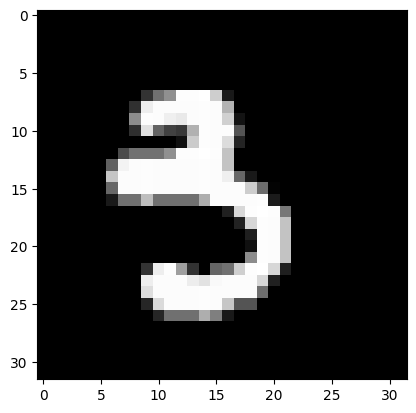

In [18]:
for idx, (inputs,label) in enumerate(test_loader):

    # move to device
    plt.imshow(inputs[0].reshape(32,32), cmap="gray")
    print(label[0])
    inputs = inputs.to(device)

    # forward pass [with feature extraction]
    preds = modelA(inputs)
    print(preds[0])
    if idx == 2:
        break

468
tensor(1)
tensor([-2.4648, 13.2356, -0.7841, -3.3614,  1.5994, -3.1586, -0.5662,  0.0871,
        -1.7180, -2.7579], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0)
tensor([12.4559, -0.7835, -2.4369, -2.6861, -1.1309, -2.6358, -0.0749, -1.1944,
        -1.9712,  0.5849], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1)
tensor([-2.0671, 12.1510, -0.5456, -1.6371, -0.5938, -1.5457, -1.6369, -1.5649,
         0.2841, -2.7507], device='cuda:0', grad_fn=<SelectBackward0>)
- preds shape: (384, 10)
- feats shape: (384, 64, 8, 8)


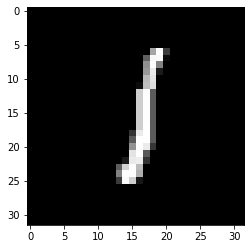

In [ ]:
##### FEATURE EXTRACTION LOOP
import matplotlib.pyplot as plt


def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

model.layer1.register_forward_hook(get_features('feats'))
# placeholders
PREDS = []
FEATS = []

# placeholder for batch features
features = {}
print(len(data_loader))
# loop through batches
for idx, (inputs,label) in enumerate(data_loader):

    # move to device
    plt.imshow(inputs[0].reshape(32,32), cmap="gray")
    print(label[0])
    inputs = inputs.to(device)

       
    # forward pass [with feature extraction]
    preds = model(inputs)
    print(preds[0])
    
    # add feats and preds to lists
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features['feats'].cpu().numpy())

    # early stop
    if idx == 2:
        break
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)

print('- preds shape:', PREDS.shape)
print('- feats shape:', FEATS.shape)

In [ ]:
##### HELPER FUNCTION FOR FEATURE EXTRACTION

In [ ]:
#add hook to layer 2
model.layer2.register_forward_hook(get_features('feats'))

In [ ]:
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)

print('- preds shape:', PREDS.shape)
print('- feats shape:', FEATS.shape)


- preds shape: (384, 10)
- feats shape: (384, 128, 4, 4)


In [ ]:
def stitching_layer(x,model):
  c1 =64
  c2= 128
  x = nn.BatchNorm2d(c1)(x)
  x = nn.Conv2d(in_channels = c1, out_channels = c2,kernel_size=1)(x)
  x = nn.BatchNorm2d(c2)(x)

  return x

stitching_layer(FEATS, model)

AttributeError: ignored

In [ ]:
PREDS[0][0]